In [ ]:
!pip install langgraph langchain_groq
!pip install python-dotenv

In [ ]:
# imports
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_groq import ChatGroq
from IPython.display import display, Image
from dotenv import load_dotenv
import os
import gradio as gr

In [ ]:
#load the api keys
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

In [ ]:
# import the env file
from google.colab import files
uploaded = files.upload()

Saving .env to .env


In [ ]:
# # is the key loaded successfully? locate key path
load_dotenv(dotenv_path=".env")  # Explicit path
groq_api_key = os.getenv("GROQ_API_KEY")

if groq_api_key:
    print("Groq API Key loaded successfully!")
else:
    print("Error: Groq API Key not found. Check your .env file.")

Groq API Key loaded successfully!


Defining the State Structure

In [ ]:
# Create the state class
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

In [ ]:
# Define the llm (chatgroq)
llm = ChatGroq(
    temperature = 0,
    groq_api_key = groq_api_key,
    model_name = "llama-3.3-70b-versatile"
)

In [ ]:
#testing
result = llm.invoke("what are the signs and symptoms of contact dermatitis")
result.content

"Contact dermatitis is a type of skin inflammation that occurs when the skin comes into contact with an irritant or allergen. The signs and symptoms of contact dermatitis can vary depending on the severity of the reaction and the individual's sensitivity. Here are some common signs and symptoms of contact dermatitis:\n\n**Mild to Moderate Symptoms:**\n\n1. **Redness and inflammation**: The affected skin area may become red, swollen, and inflamed.\n2. **Itching and burning**: The skin may feel itchy, burning, or prickly, especially after contact with the irritant or allergen.\n3. **Rash or blisters**: A rash or blisters may appear on the affected skin area, which can be small, raised, and fluid-filled.\n4. **Dryness and scaling**: The skin may become dry, scaly, or flaky, especially if the reaction is chronic.\n5. **Crusting or oozing**: In some cases, the skin may develop a crust or ooze a clear fluid.\n\n**Severe Symptoms:**\n\n1. **Intense itching and burning**: The itching and burni

Defining the Node Function

In [ ]:
#categorizing function- technical, Billing, or General
def categorize(state : State) -> State:
     "Technical, Billing, General"
     prompt = ChatPromptTemplate.from_template(
      "Categorize the following customer query into one of these categories: "
      "Technical, Billing, General. Query: {query}"
     )
     chain = prompt | llm
     category = chain.invoke({"query" : state['query']}).content
     return {"category": category}

In [ ]:
# analyzing sentiment function_ how is the customer feeling?
def analyze_sentiment(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | llm
    sentiment = chain.invoke({"query": state['query']}).content  # Capture sentiment
    return {"sentiment": sentiment}  # Return sentiment instead of category

In [ ]:
#handle technical function
def handle_technical(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query : {query}"

    )
    chain = prompt | llm
    response = chain.invoke({"query" : state['query']}).content
    return {"response" : response}

In [ ]:
#handling billing function
def handle_billing(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query : {query}"

    )
    chain = prompt | llm
    response = chain.invoke({"query" : state['query']}).content
    return {"response" : response}

In [ ]:
#handle general
def handle_general(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query : {query}"

    )
    chain = prompt | llm
    response = chain.invoke({"query" : state['query']}).content
    return {"response" : response}

In [ ]:
#escalate the situation
def escalate(state : State) -> State:
    return{"response" : "This query has been escalated to a human agent due to its negative sentiment"}

In [ ]:
result = llm.invoke(" I am not happy at all. Been experiencing technical problems since Friday")
result.content

"I'm so sorry to hear that you're experiencing technical problems and it's been going on since Friday. That can be really frustrating and stressful.\n\nCan you tell me more about the issues you're facing? What kind of technical problems are you experiencing? Is it with your computer, phone, internet, or something else? Maybe I can help you troubleshoot or offer some suggestions to get you back up and running smoothly."

In [ ]:
result = llm.invoke("I was charged twice for my subscription")
result.content

"That's frustrating. If you've been charged twice for your subscription, here are some steps you can take to resolve the issue:\n\n1. **Check your account**: Log in to your account and review your subscription details to confirm that you've been charged twice.\n2. **Contact customer support**: Reach out to the company's customer support team via phone, email, or live chat. Explain the situation and provide them with your account information, including the dates and amounts of the duplicate charges.\n3. **Provide proof of payment**: Be prepared to provide proof of payment, such as a receipt or a bank statement, to support your claim.\n4. **Request a refund**: Ask the customer support team to refund the duplicate charge as soon as possible.\n5. **Check for automatic payment settings**: Make sure that you don't have automatic payment settings enabled, which could be causing the duplicate charges.\n\nSome additional tips:\n\n* **Act quickly**: The sooner you report the issue, the faster it

In [ ]:
result = llm.invoke("Thank you for all your help")
result.content

"You're welcome. It was my pleasure to assist you. If you have any other questions or need further assistance, feel free to ask. Have a great day."

In [ ]:
# handling the routing function
def route_query(state: State) -> State:
    if state['sentiment'] == 'Negative':
        return "escalate"
    elif state['category'] == 'Technical':
        return "handle_technical"
    elif state['category'] == 'Billing':
        return "handle_billing"
    else:
        return "handle_general"

Developing the Workflow

In [ ]:
#crafting the workflow
workflow = StateGraph(State)
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

In [ ]:
#adding edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges("analyze_sentiment",
route_query,{
    "handle_technical" : "handle_technical",
    "handle_billing": "handle_billing",
    "handle_general" : "handle_general",
    "escalate": "escalate"
})
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

In [ ]:
#adding the entry point
workflow.set_entry_point("categorize")

#compile the workflow
app = workflow.compile()

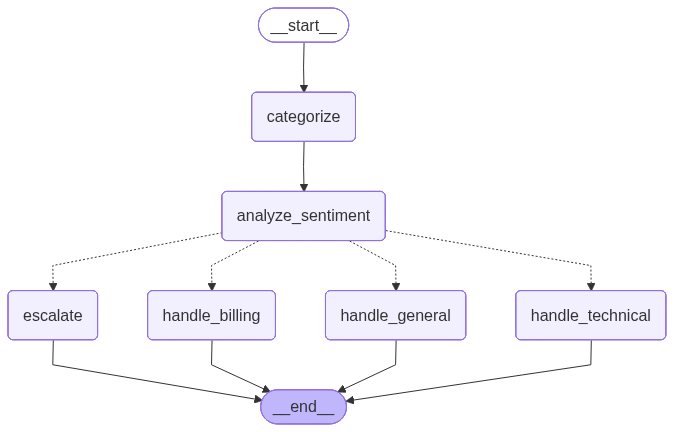

In [ ]:
#vizualise the graph
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )

))

Running The Customer Support Function

In [ ]:
# Function to run customer support
def run_customer_support(query: str) -> dict:
    result = app.invoke({"query": query})
    return {
        "category": result['category'],
        "sentiment": result['sentiment'],
        "response": result['response'],
    }

In [ ]:
# test
query = "where are your offices located?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: where are your offices located?
Category: I would categorize the customer query "where are your offices located?" as General. This query is asking for basic information about the company's location, which is not related to technical support or billing issues.
Sentiment: Neutral.
Response: Thank you for reaching out to us. We appreciate your interest in learning more about our organization. 

Our offices are strategically located in various regions to better serve our customers and clients. For the most up-to-date and accurate information on our office locations, I recommend visiting our official website or contacting our customer support team directly. They will be more than happy to provide you with the information you need.

If you have any other questions or need assistance with anything else, please don't hesitate to ask. We're here to help and look forward to the opportunity to support you further.




In [ ]:
# Create the Gradio interface
def gradio_interface(query: str):
    result = run_customer_support(query)
    return (
        f"**Category:** {result['category']}\n\n"
        f"**Sentiment:** {result['sentiment']}\n\n"
        f"**Response:** {result['response']}"
    )

In [ ]:
# Build the Gradio app
gui = gr.Interface(
    fn=gradio_interface,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=gr.Textbox(lines=2, placeholder="Enter your query here..."),
    outputs=gr.Markdown(),
    title="Customer Support Assistant",
    description="Provide a query and receive a categorized response. The system analyzes sentiment and routes to the appropriate support channel.",
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


theme_schema%400.0.1.json: 0.00B [00:00, ?B/s]

In [ ]:
# Launch the app
if __name__ == "__main__":
    gui.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://90b53e3e78a6e9f9fa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
